In [31]:
import os
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler



### Prepare DataSet

In [32]:
PATH = "./DataSet/"

In [33]:
import os
import pandas as pd

directory_list = os.listdir(PATH)
if '.DS_Store' in directory_list:
    directory_list.remove('.DS_Store')

file_label = []
file_path = []

for folder in directory_list:
    for file in os.listdir(os.path.join(PATH, folder)):
        if folder == 'Normal':
            file_label.append('N')
        elif folder == 'Faulty':
            file_label.append('F')
        else:
            file_label.append('X')
        file_path.append(os.path.join(PATH, folder, file))

label_df = pd.DataFrame(file_label, columns=['Label'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([path_df, label_df], axis=1)

# Shuffle the DataFrame with a fixed random seed
crema_df = crema_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output or save the DataFrame if needed
print(crema_df)


                                       Path Label
0           ./DataSet/Normal/Normal1_18.wav     N
1    ./DataSet/Non-Stamp/Non_Normal3_01.wav     X
2    ./DataSet/Non-Stamp/Non_Normal3_07.wav     X
3           ./DataSet/Faulty/Faulty1_72.wav     F
4        ./DataSet/Non-Stamp/Faulty1_40.wav     X
..                                      ...   ...
361      ./DataSet/Non-Stamp/Faulty2_36.wav     X
362      ./DataSet/Non-Stamp/Faulty1_03.wav     X
363         ./DataSet/Normal/Normal3_60.wav     N
364         ./DataSet/Faulty/Faulty1_13.wav     F
365      ./DataSet/Non-Stamp/Faulty1_07.wav     X

[366 rows x 2 columns]


In [34]:
crema_df.to_csv("stampingDataSet.csv", index = False)
crema_df.head()

Path Label
0         ./DataSet/Normal/Normal1_18.wav     N
1  ./DataSet/Non-Stamp/Non_Normal3_01.wav     X
2  ./DataSet/Non-Stamp/Non_Normal3_07.wav     X
3         ./DataSet/Faulty/Faulty1_72.wav     F
4      ./DataSet/Non-Stamp/Faulty1_40.wav     X

In [35]:
path = np.array(crema_df.Path)[5]
data, sample_rate = librosa.load(path)
path

'./DataSet/Normal/Normal2_60.wav'

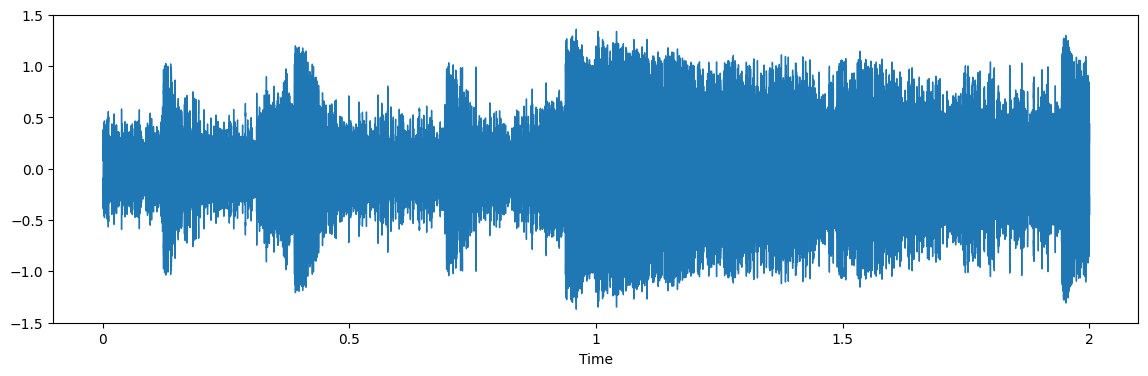

In [36]:
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = data, sr = sample_rate)
Audio(path)

In [40]:
# def extract_features(data):
#     result = np.array([])
#     mfcc = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 13)
#     mfcc_flat = mfcc.flatten()
#     result = np.hstack((result, mfcc_flat))

#     return result

# def get_features(path):
#     data, sample_rate = librosa.load(path, duration = 2, offset = 0.6)

#     res1 = extract_features(data)
#     result = np.array(res1)
    
#     return result


def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 13).T, axis = 0)
    result = np.hstack((result, mfcc))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)
    return result


In [41]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, label, X, Y):
    feature = get_features(path)
    X.append(feature)
    Y.append(label)
    # for ele in feature:
    #     X.append(ele)
    #     Y.append(label)
    # return (path, label)
    return (X, Y)

X , Y = [], []

with ThreadPoolExecutor() as executor:
        features = []
        for path, stamping in zip(crema_df.Path, crema_df.Label):
            feature = executor.submit(process_audio_file, path, stamping, X, Y)
            features.append(feature)

        for future in features:
            path, stamping = feature.result()


/var/folders/df/x3g54_dx68l8b8znh64gwd6c0000gn/T/ipykernel_53736/317988020.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration = 2, offset = 0.6)


In [42]:
features = pd.DataFrame(X)
features['labels'] = Y

features.head()

0          1         2          3          4          5         6  \
0  70.940666  22.094328 -3.493124  25.696556 -15.566960   7.296114 -5.072011   
1  16.411598  40.614719  4.932045  22.898985 -21.343855   6.656966 -8.136959   
2  89.251602  49.369640 -1.724817  30.004671  -9.325487  10.869224 -4.079087   
3  47.512856  59.009815  6.688692  28.098537 -16.207563   7.581295 -6.513551   
4  48.916721  38.651539 -7.207287  30.065983 -11.941235   7.409690 -7.264763   

          7         8         9        10        11        12 labels  
0  1.142267 -5.674940 -1.160710 -0.148213 -0.420398 -1.656111      F  
1 -2.932705 -6.521407 -1.867065  5.877697 -0.804423 -0.111440      X  
2  1.077554 -2.636487 -1.576163 -2.623979  1.626988 -1.065563      N  
3 -1.634421 -5.125853 -3.170660  1.557568 -3.347545 -1.716344      X  
4 -1.445566 -6.293025 -0.855398  1.409301  0.620569 -0.784461      X

In [43]:
features.to_csv('StampingFeature.csv', index = False)
features.head()

0          1         2          3          4          5         6  \
0  70.940666  22.094328 -3.493124  25.696556 -15.566960   7.296114 -5.072011   
1  16.411598  40.614719  4.932045  22.898985 -21.343855   6.656966 -8.136959   
2  89.251602  49.369640 -1.724817  30.004671  -9.325487  10.869224 -4.079087   
3  47.512856  59.009815  6.688692  28.098537 -16.207563   7.581295 -6.513551   
4  48.916721  38.651539 -7.207287  30.065983 -11.941235   7.409690 -7.264763   

          7         8         9        10        11        12 labels  
0  1.142267 -5.674940 -1.160710 -0.148213 -0.420398 -1.656111      F  
1 -2.932705 -6.521407 -1.867065  5.877697 -0.804423 -0.111440      X  
2  1.077554 -2.636487 -1.576163 -2.623979  1.626988 -1.065563      N  
3 -1.634421 -5.125853 -3.170660  1.557568 -3.347545 -1.716344      X  
4 -1.445566 -6.293025 -0.855398  1.409301  0.620569 -0.784461      X

### EDA

In [45]:
data = pd.read_csv("StampingFeature.csv")
data.head()

0          1         2          3          4          5         6  \
0  70.940666  22.094328 -3.493124  25.696556 -15.566960   7.296114 -5.072011   
1  16.411598  40.614719  4.932045  22.898985 -21.343855   6.656966 -8.136959   
2  89.251602  49.369640 -1.724817  30.004671  -9.325487  10.869224 -4.079087   
3  47.512856  59.009815  6.688692  28.098537 -16.207563   7.581295 -6.513551   
4  48.916721  38.651539 -7.207287  30.065983 -11.941235   7.409690 -7.264763   

          7         8         9        10        11        12 labels  
0  1.142267 -5.674940 -1.160710 -0.148213 -0.420398 -1.656111      F  
1 -2.932705 -6.521407 -1.867065  5.877697 -0.804423 -0.111440      X  
2  1.077554 -2.636487 -1.576163 -2.623979  1.626988 -1.065563      N  
3 -1.634421 -5.125853 -3.170660  1.557568 -3.347545 -1.716344      X  
4 -1.445566 -6.293025 -0.855398  1.409301  0.620569 -0.784461      X

In [46]:
data["labels"] = data["labels"].map({"F": 1, "N": 0, "X": -1})

In [47]:
X  = data.drop(columns="labels")
y = data["labels"]

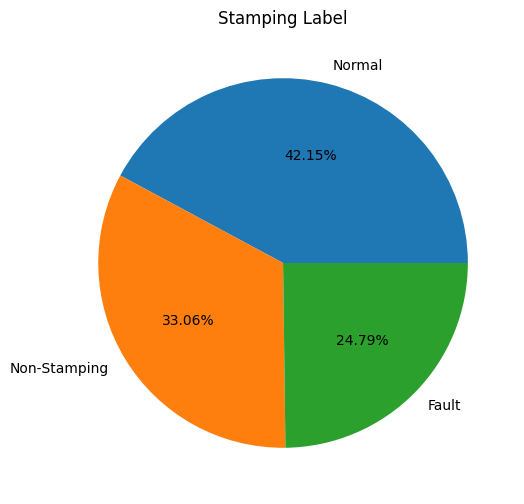

In [48]:
# Visualize Pie Chart
label = [
    'Fault' if i == 1 
    else 'Normal' if i == 0 
    else 'Non-Stamping' if i == -1 
    else 'Unknown'  # Optional: handle unexpected cases
    for i in y.value_counts().index
]


plt.figure(figsize=(10, 6))
plt.pie(y.value_counts(), labels=label, autopct="%.02f%%")
plt.title("Stamping Label")
# plt.savefig('piechart', dpi=300, bbox_inches='tight')
plt.show()

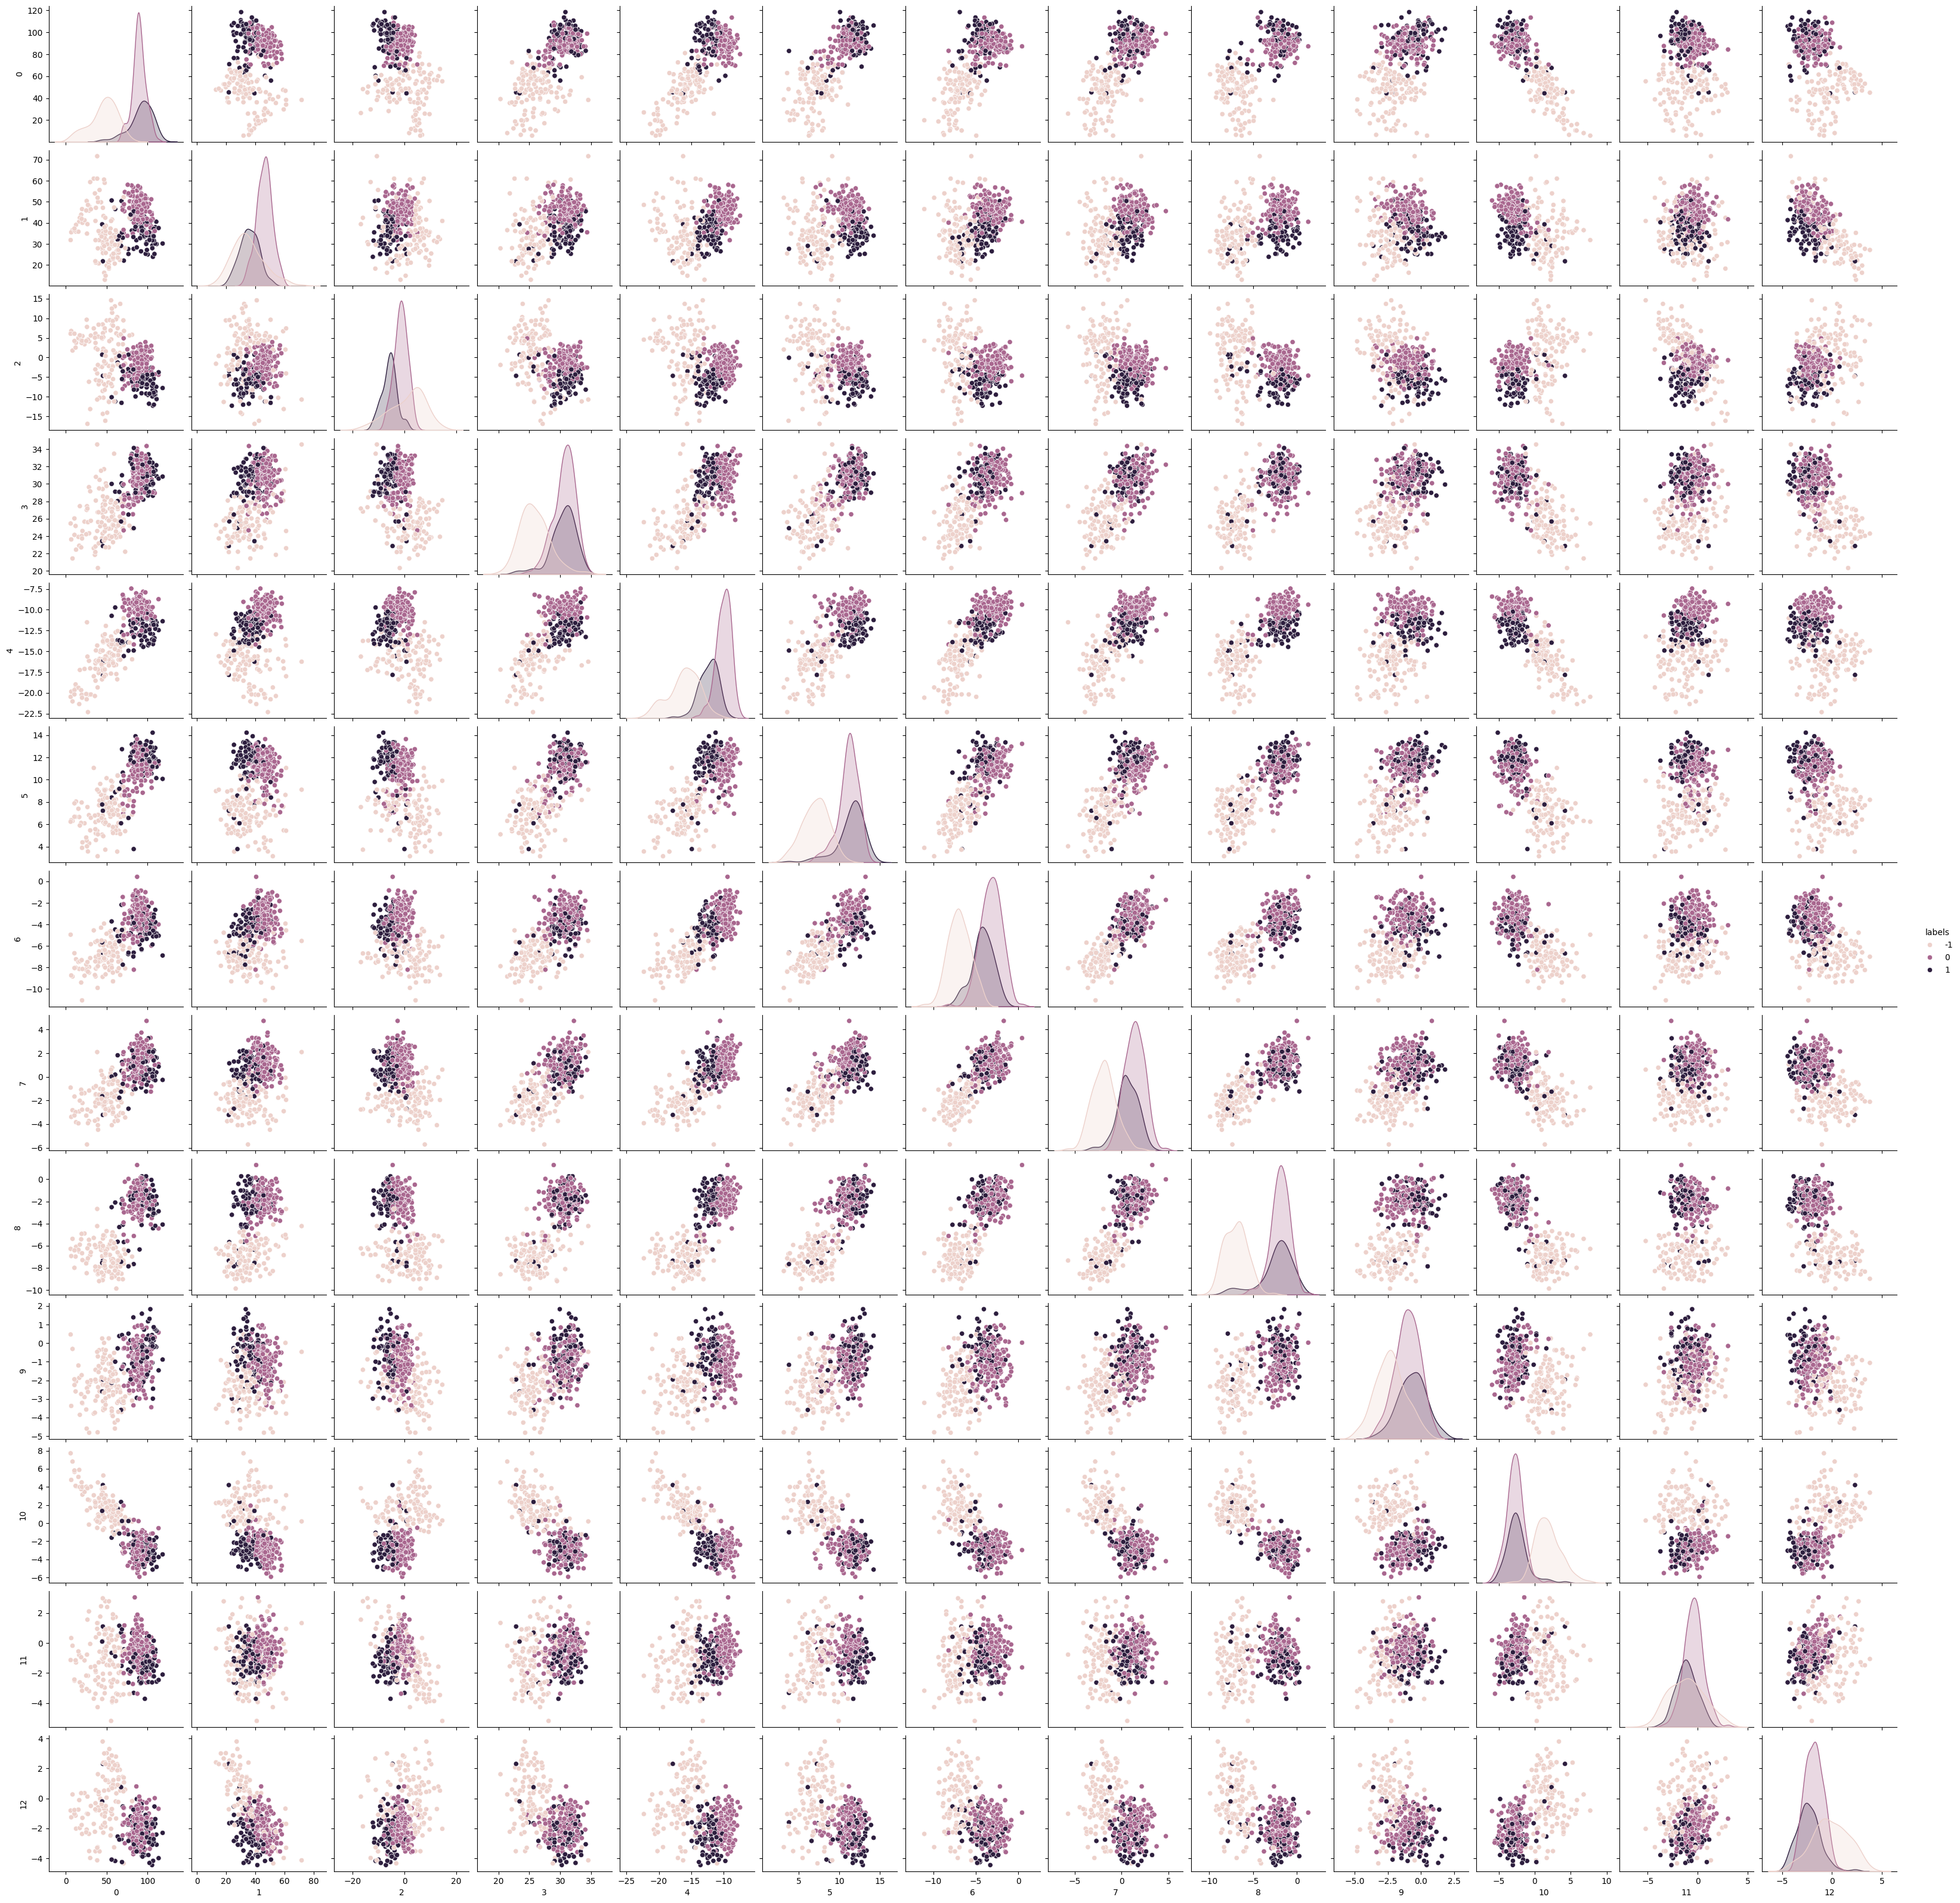

In [50]:
sns.pairplot(data, hue="labels")